In [1]:
!nvidia-smi

Tue Mar  5 13:21:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:11:00.0 Off |                    0 |
| N/A   32C    P0              54W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [1]:
# !git clone https://github.com/tldrafael/DeepLabV3Plus-Pytorch
# !mv DeepLabV3Plus-Pytorch deeplabv3

Cloning into 'DeepLabV3Plus-Pytorch'...
remote: Enumerating objects: 777, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 777 (delta 23), reused 36 (delta 23), pack-reused 734
Receiving objects: 100% (777/777), 8.26 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (435/435), done.


In [24]:
# !apt install -y wget zip
# !wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hssswvmjwf-1.zip
# !unzip -d. hssswvmjwf-1.zip 
# !unzip -d. 'Road Traversing Knowledge/RTK.zip'

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
from deeplabv3 import deeplabv3plus_resnet50

Backbone HRNet Pretrained weights at: ./checkpoints/hrnetv2_32_model_best_epoch96.pth, only usable for HRNetv2-32


In [4]:
from torchvision.io import read_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
from seaborn import color_palette
from PIL import Image
from torch import nn


def set_randomseed(seed=None, return_seed=False):
    
    if seed is None:
        seed = np.random.randint(2147483647)
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    if return_seed:
        return seed

normalize_back =  T.Normalize(
            mean=[-.485/.229, -.456/.224, -.406/.225],
            std=[1/.229, 1/.224, 1/.225])


class SimpleDataset(Dataset):
    
    def __init__(
        self, annotation_file, dirbase=None, has_label=True,
        transform=None, transform_target=None,
        transform_color=None, ix_nolabel=255, fl_normalize=True, **kwargs
    ):

        with open(annotation_file, 'r') as f:
            self.impaths = f.read().split('\n')[:-1]

        if dirbase is not None:
            self.impaths = [os.path.join(dirbase, p) for p in self.impaths]

        if has_label:
            self.labelpaths = [p.replace('/image/', '/label/') for p in self.impaths]

        self.dirbase = dirbase
        self.has_label = has_label
        self.transform = transform
        self.transform_color = transform_color
        self.fl_transform_color = transform_color is not None
        self.transform_target = transform_target
        self.ix_nolabel = ix_nolabel
        self.fl_normalize = fl_normalize

        self.normalize =  T.Normalize(
            mean=[.485, .456, .406], std=[.229, .224, .225])

        self.remap_labels = torch.concat([
            torch.arange(8),
            torch.tensor([-1]),
            torch.arange(8, 12)
        ])

    
    def __len__(self):
        return len(self.impaths)

    def __getitem__(self, idx):
        image = read_image(self.impaths[idx])

        if self.fl_transform_color:
            # The color transformation doesn't follow the set seed.
            image = self.transform_color(image)

        if self.transform:
            state = set_randomseed(return_seed=True)
            image = self.transform(image)

        if self.has_label:
            label = read_image(self.labelpaths[idx])

            if self.transform:
                set_randomseed(seed=state)
                label = self.transform_target(label).to(torch.uint8)

            label = label.long()
            label = self.remap_labels[label]
            
            assert (label != self.ix_nolabel).all(), \
                f'shouldn\'t have any label of class {self.ix_nolabel}'
        else:
            label = self.ix_nolabel + torch.zeros(image.shape, dtype=torch.long)

        if self.fl_normalize:
            return self.normalize(image / 255), label
        else:
            return image, label


def plot_grid(inp, fl_normalize_back=False):
    tmp = inp.clone()
    if fl_normalize_back:
        tmp = normalize_back(tmp)
    
    tmp = tmp.moveaxis(0, -2).flatten(-2, -1).permute(1,2,0)
    plt.imshow(tmp)
    plt.show()


class Colorizer:

    def __init__(self, n_classes):
        range = np.linspace(0, 1, n_classes)
        colors = color_palette('gist_rainbow', as_cmap=True)(range)
        colors = colors[..., :3]
        colors = np.concatenate([np.array([[0,0,0]]), colors])
        self.colors = colors

    def __call__(self, classmap):
        return self.colors[classmap]


class TorchColorizer(Colorizer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.colors = torch.Tensor(self.colors)

    def __call__(self, classmap):
        tmp = self.colors[classmap]
        return tmp.permute(0,4,2,3,1)[...,0]


def float_to_uint8(x):
    return (x*255).round().clip(0,255).astype(np.uint8)

In [5]:
crop_size = (224, 224)

T_crop = T.Compose([
    T.RandomCrop(size=crop_size),
    T.RandomHorizontalFlip(p=.5)
])

train_ds = SimpleDataset(
    annotation_file='RTK/trainpaths.txt', dirbase='RTK/',
    transform=T_crop, transform_target=T_crop
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

In [6]:
for inp_im, inp_label in train_loader:
    break
    

dummy_im = inp_im.clone()[:6]
dummy_label = inp_label.clone()[:6]

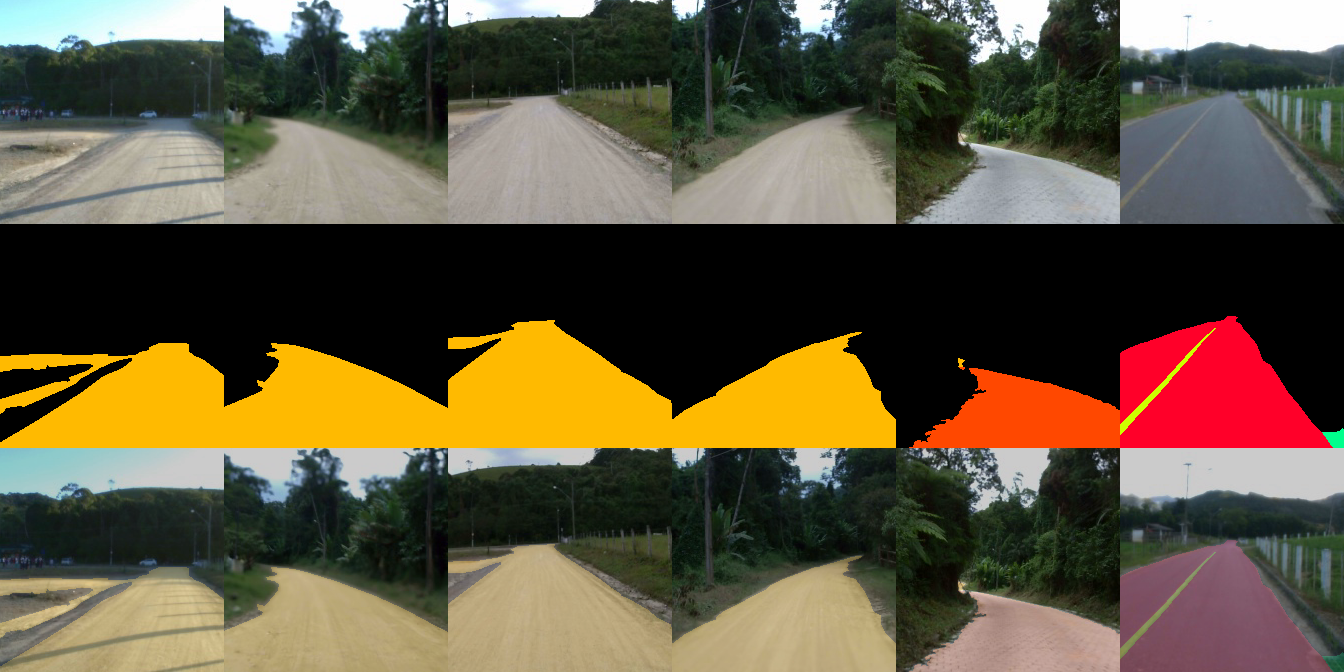

In [7]:
colorizer = TorchColorizer(13)

ims = normalize_back(dummy_im)
labels = colorizer(dummy_label)
alpha = .2
blend = (1-alpha)*ims + alpha*labels

tmp = torch.concat([ims, labels, blend], axis=-2)
tmp = tmp.moveaxis(0,-2).flatten(-2,-1).permute(1,2,0)
tmp = float_to_uint8(tmp.numpy())
Image.fromarray(tmp)

In [10]:

# n_classes = 12
# model = deeplabv3plus_resnet50(**tr_params, num_classes=n_classes)


# ix_nolabel = 255
# CE = nn.CrossEntropyLoss(reduction='mean', ignore_index=ix_nolabel)

# opt = torch.optim.AdamW(
#     model.parameters(), lr=1e-4
# )


# tr_params = {
#     'fl_stemstride': True,
#     'fl_richstem': False,
#     'fl_parallelstem': False,
#     'fl_maxpool': False,
#     'fl_lfe': False,
#     'fl_transpose': False,
# }


In [11]:
# model.train().cuda()

# print_every_n = 10

# ep_i = 1
# ep_total = 10000

# losses = []

# while ep_i <= ep_total:

#     lossi = []
#     for inp_im, inp_label in train_loader:
#         inp_im = inp_im.cuda()
#         inp_label = inp_label.cuda()
        
#         pred = model(inp_im)
#         loss = CE(pred, inp_label[:, 0])
    
#         opt.zero_grad(set_to_none=True)
#         loss.backward()
#         opt.step()

#         lossi.append(loss.item())
    

#     loss_avg = np.mean(lossi)
#     losses.append(loss_avg)
    
#     print(f'ep: {ep_i}\tloss: {loss_avg:.2f}')
#     ep_i += 1

    
#     model.eval()
#     pred = model(dummy_im.cuda()).cpu().argmax(1, keepdim=True)
#     ims = normalize_back(dummy_im)
#     labels = colorizer(pred)
#     alpha = .2
#     blend = (1-alpha)*ims + alpha*labels
#     tmp = torch.concat([ims, labels, blend], axis=-2)
#     tmp = tmp.moveaxis(0,-2).flatten(-2,-1).permute(1,2,0)
#     tmp = float_to_uint8(tmp.numpy())
#     # Image.fromarray(tmp)
#     plt.figure(figsize=(20,10))
#     plt.imshow(tmp)
#     plt.axis('off')
#     plt.show()
#     model.train()
    

In [12]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter



def compute_diceloss(
    pred, label, conf_thrs=None, return_mean=True, n_classes=12, ignore_index=255
):
    
    if ignore_index in label:
        label[label == ignore_index] = n_classes
        label_onehot = F.one_hot(label, num_classes=n_classes + 1).permute(0, 3, 1, 2)
        label_onehot = label_onehot[:, :n_classes]
    else:
        label_onehot = F.one_hot(label, num_classes=n_classes).permute(0, 3, 1, 2)

    assert label_onehot.shape == pred.shape

    if conf_thrs is None:
        dice_score = (label_onehot * pred).sum([0, 2, 3]) / (label_onehot + pred).sum([0, 2, 3]).clamp_min(1e-3)
    else:
        conf_mask = 1. * (pred.amax(1, keepdim=True) >= conf_thrs)
        denom = ((label_onehot + pred) * conf_mask).sum([0, 2, 3]).clamp_min(1e-3)
        dice_score = (label_onehot * pred * conf_mask).sum([0, 2, 3]) / denom

    if return_mean:
        return 1 - dice_score.mean()
    else:
        return 1 - dice_score


def get_CM(pred, label, n_classes):
    cm = np.bincount(
        n_classes * label.flatten() + pred.flatten(),
        minlength=n_classes ** 2)
    
    return cm.reshape(
        n_classes, n_classes, order='F').astype(int)


def get_CM_fromloader(dloader, model, n_classes, ix_nolabel=255):
    # https://github.com/Qualcomm-AI-research/InverseForm/blob/be142136087579d5f7175cbf64c171fc52352fc7/utils/misc.py#L20
    # stretch ground truth labels by num_classes
    # TP at 0 + 0, 1 + 1, 2 + 2 ...  # TP exist where value == num_classes*class_id + class_id
    # FP = row[class].sum() - TP
    # FN = col[class].sum() - TP
    CM_abs = np.zeros((n_classes, n_classes), dtype=int)
    
    for inp_data, inp_label in dloader:
        
        test_preds = model(inp_data.cuda())
        test_preds = test_preds.argmax(1, keepdim=True).cpu()
        
        for pr_i, y_i in zip(test_preds, inp_label):
            
            if ix_nolabel is None:
                CM_abs += get_CM(pr_i, y_i, n_classes)
            else:
                if (pr_i == ix_nolabel).sum().item() > 0:
                    warnings.warn(
                        'The model has also predicted ix_nolabel value, '
                        'these pixels are also being ignored '
                        ' - thus, this metric is not correct!'
                    )
                
                mask = (y_i != ix_nolabel) & (pr_i != ix_nolabel)
                CM_abs += get_CM(pr_i[mask], y_i[mask], n_classes)

    
    pred_P = CM_abs.sum(axis=0)
    gt_P = CM_abs.sum(axis=1)
    true_P = np.diag(CM_abs)

    CM_iou = true_P / (pred_P + gt_P - true_P)
    miou = np.nanmean(CM_iou)
    return miou, CM_iou, CM_abs


class WarmupLR(_LRScheduler):

    def __init__(
        self, optimizer, min_lr_factor=0.001, logger=None,
        n_warmup_max=5, **kwargs
    ):

        # avoid lr changes after calling super
        base_lrs_bkp = [pg['lr'] for pg in optimizer.param_groups]
        
        self.min_lr_factor = min_lr_factor
        self.n_warmup_max = n_warmup_max
        self.n_warmup = 1
        self.fl_warmup = True
        
        super().__init__(optimizer)
        self.base_lrs = base_lrs_bkp

    def get_lr(self):
        wu_lrs = []
        if self.fl_warmup:
            for blr in self.base_lrs:
                wu_lr = blr * self.min_lr_factor + \
                    blr * (1 - self.min_lr_factor) * \
                    (self.n_warmup - 1) / self.n_warmup_max
                wu_lrs.append(wu_lr)

            self.n_warmup += 1.
            if self.n_warmup > (self.n_warmup_max + 1):
                self.fl_warmup = False
        else:
            wu_lrs = self.base_lrs

        return wu_lrs



def save_ckpt(p, model, opt, miou_val):
    torch.save({
        'state': model.state_dict(),
        'opt_state': opt.state_dict(),
        'best_miou': miou_val
    }, p)


In [13]:

tr_params = {
    'fl_stemstride': True,
    'fl_richstem': False,
    'fl_parallelstem': False,
    'fl_maxpool': False,
    'fl_lfe': False,
    'fl_transpose': False,
}


n_classes = 12
model = deeplabv3plus_resnet50(**tr_params, num_classes=n_classes)

In [14]:
ix_nolabel = 255
CE = nn.CrossEntropyLoss(reduction='mean', ignore_index=ix_nolabel)

# opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
opt = torch.optim.SGD(
    model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)


scheduler = WarmupLR(opt, n_warmup_max=10)
warmup_step = 200

time_now = datetime.now().strftime("%Y%m%d_%H%M")
time_now += '-test-shuffleTrue'
logdir = os.path.join('logs', time_now)
writer = SummaryWriter(log_dir=logdir)


writer.flush()

In [15]:
val_ds = SimpleDataset(annotation_file='RTK/valpaths.txt', dirbase='RTK/')
val_loader = DataLoader(val_ds, batch_size=1)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

In [18]:
# for pg in opt.param_groups:
#     pg['lr'] *= .1
#     print(pg['lr'])

0.001


In [20]:
model.train().cuda()

print_every_n = 1000

iters_total = 200000

# it = 1
# losses = []
# miou_best = 0
# steps_cur = 0

lossi = []
lossi_ce = []
lossi_dice = []

lr_cur = opt.param_groups[0]["lr"]
print(f'lr: {lr_cur:.2e}')
writer.add_scalars('lr', {'nn': lr_cur}, steps_cur)


model.eval()
miou_train = get_CM_fromloader(train_loader, model, n_classes)[0]
miou_val = get_CM_fromloader(val_loader, model, n_classes)[0]
print(f'\tmiou-train: {miou_train:.2f}\tmiou-val: {miou_val:.2f}')
writer.add_scalars('miou', {'train': miou_train}, steps_cur)
writer.add_scalars('miou', {'val': miou_val}, steps_cur)


model.train()
while it <= iters_total:

    for inp_im, inp_label in train_loader:
        inp_im = inp_im.cuda()
        inp_label = inp_label[:, 0].cuda()
        
        pred = model(inp_im)
        loss_ce = CE(pred, inp_label)
        loss_dice = compute_diceloss(pred.softmax(1), inp_label)

        loss = loss_ce + loss_dice
        # loss = loss_ce
        
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        lossi.append(loss.item())
        lossi_ce.append(loss_ce.item())
        lossi_dice.append(loss_dice.item())
        it += 1

        if scheduler.fl_warmup and it % warmup_step == 0:
            scheduler.step()
            print(f'lr: {opt.param_groups[0]["lr"]:.2e}')
        
        if it % print_every_n == 0:
            steps_cur += 1

            loss_avg = np.mean(lossi)
            losses.append(loss_avg)

            loss_avg_dice = np.mean(lossi_dice)
            loss_avg_ce = np.mean(lossi_ce)            
            
            model.eval()
            miou_train = get_CM_fromloader(train_loader, model, n_classes)[0]
            miou_val = get_CM_fromloader(val_loader, model, n_classes)[0]
            model.train()

            print(f'it: {it}\tloss: {loss_avg:.4f}\t'
                  f'loss-ce: {loss_avg_ce:.4f}\tloss-dice: {loss_avg_dice:.4f}',
                  f'\tmiou-train: {miou_train:.3f}\tmiou-val: {miou_val:.3f}'
            )

            writer.add_scalars('objective', {'train': loss_avg}, steps_cur)
            writer.add_scalars('CE', {'train': loss_avg_ce}, steps_cur)
            writer.add_scalars('diceloss', {'train': loss_avg_dice}, steps_cur)
            writer.add_scalars('miou', {'train': miou_train}, steps_cur)
            writer.add_scalars('miou', {'val': miou_val}, steps_cur)

            
            lossi = []
            lossi_ce = []
            lossi_dice = [] 

            ckpt_last_path = os.path.join(logdir, 'model.last.pth')
            save_ckpt(ckpt_last_path, model, opt, miou_val)

            if miou_val > miou_best:
                miou_best = miou_val
                ckpt_last_path = os.path.join(logdir, 'model.best.pth')
                save_ckpt(ckpt_last_path, model, opt, miou_val)

lr: 1.00e-03
	miou-train: 0.91	miou-val: 0.76
it: 26000	loss: 0.6906	loss-ce: 0.0115	loss-dice: 0.6791 	miou-train: 0.913	miou-val: 0.764
it: 27000	loss: 0.6918	loss-ce: 0.0113	loss-dice: 0.6805 	miou-train: 0.916	miou-val: 0.764
it: 28000	loss: 0.6913	loss-ce: 0.0112	loss-dice: 0.6801 	miou-train: 0.919	miou-val: 0.765
it: 29000	loss: 0.6888	loss-ce: 0.0110	loss-dice: 0.6778 	miou-train: 0.917	miou-val: 0.763
it: 30000	loss: 0.6882	loss-ce: 0.0111	loss-dice: 0.6771 	miou-train: 0.919	miou-val: 0.763
it: 31000	loss: 0.6901	loss-ce: 0.0109	loss-dice: 0.6792 	miou-train: 0.924	miou-val: 0.759
it: 32000	loss: 0.6892	loss-ce: 0.0107	loss-dice: 0.6785 	miou-train: 0.920	miou-val: 0.764
it: 33000	loss: 0.6900	loss-ce: 0.0106	loss-dice: 0.6794 	miou-train: 0.918	miou-val: 0.762
it: 34000	loss: 0.6894	loss-ce: 0.0106	loss-dice: 0.6788 	miou-train: 0.922	miou-val: 0.765
it: 35000	loss: 0.6904	loss-ce: 0.0105	loss-dice: 0.6799 	miou-train: 0.925	miou-val: 0.763
it: 36000	loss: 0.6875	loss-ce: 0.

KeyboardInterrupt: 

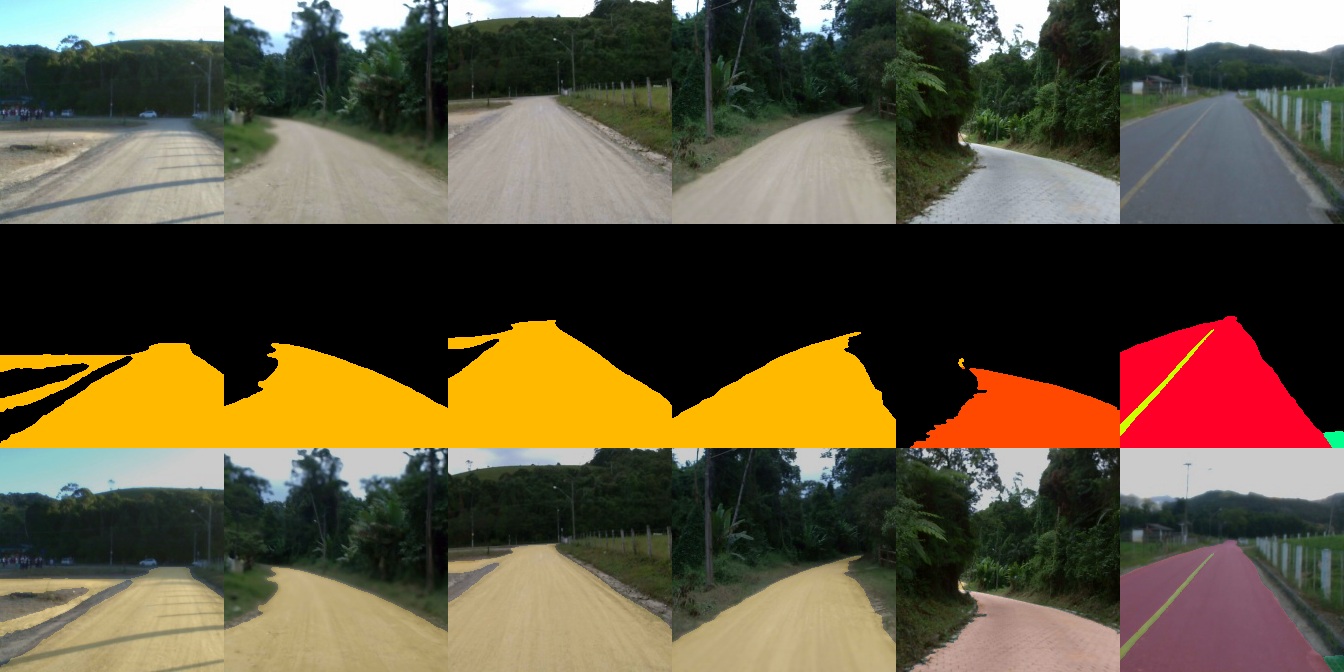

In [23]:
model.eval()
pred = model(dummy_im.cuda()).cpu().argmax(1, keepdim=True)
ims = normalize_back(dummy_im)
# labels = colorizer(dummy_label)
labels = colorizer(pred)
alpha = .2
blend = (1-alpha)*ims + alpha*labels
tmp = torch.concat([ims, labels, blend], axis=-2)
tmp = tmp.moveaxis(0,-2).flatten(-2,-1).permute(1,2,0)
tmp = float_to_uint8(tmp.numpy())
Image.fromarray(tmp)